# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import json
import sys
import os
import logging
from dotenv import load_dotenv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import optuna

from collections import Counter
from typing import Optional

from sklearn.metrics import mean_absolute_error, mean_squared_error

from bb_energy_prediction import embedder, models, data_utils, train, dataset, evaluate

load_dotenv()

c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=1)

# Data

In [3]:
no_dupl = False
if no_dupl:
    data_df = data_utils.get_data_df(data_path="../energy_data/no_dupl_data.pkl")
else:
    data_df = data_utils.get_data_df(data_path="../energy_data/data.pkl")

if "bb_embeddings" in data_df.columns:
    data_df = data_df.drop(columns="bb_embeddings")

We create the vocab and tokenize the data

In [4]:
vocab = data_utils.get_inst_vocab(data_df)
print(f"size of vocabulary: {len(vocab)}")

size of vocabulary: 3359


We remove outliers in order to have more balanced padded sequences

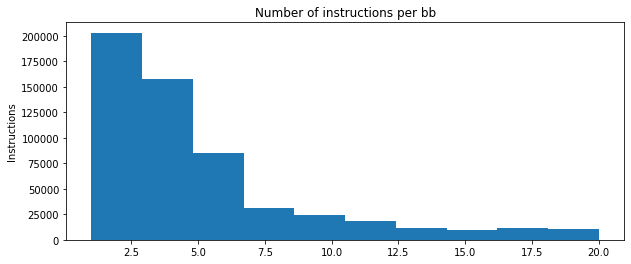

In [5]:
plt.figure(figsize=(10,4))
plt.hist(data_df.bb.map(len))
plt.title("Number of instructions per bb")
plt.ylabel("Instructions")
plt.show()

In [6]:
data_df["encoded_bb"] = data_df.bb.apply(lambda x: data_utils.encode_bb_from_vocab(x, vocab, max_insts=20))
data_df.sample(10)

,bb,energy,program_name,encoded_bb
357461,"[movq %rdi, movq %r15, cmpq %r15, jz 0x26]",0.030069,variable_name,"[12, 101, 331, 389]"
182328,"[sub $0x1 %rax, cmpb $0xa (%rax), jz 0x111]",0.254436,ip_get,"[9, 10, 11]"
98866,"[movsx %r15b %eax, lea %rsi, sub $0x20 %eax, c...",0.023618,find_dyn_sum,"[168, 49, 167, 50, 39, 36, 3, 34, 427, 764, 76..."
227332,"[cmp %rax %r12, jb]",0.163123,ip,"[8, 6]"
135881,"[cmp %r9d, jz]",0.282755,function_pointer,"[715, 38]"
213473,"[cmp %r10d, jnbe]",0.163123,ip,"[735, 67]"
195395,"[cmp $0xa %ebx, jz 0xa3]",0.008835,ip,"[300, 298]"
37234,"[cmp $0x20 %rdx, jb 0x4b]",0.000100,find_biggest,"[73, 76]"
365745,"[movl (%r12) %r15d, test $0x8 %r15b, jnz 0x249b]",0.170516,variable_name,"[343, 342, 344]"
356140,[jnle 0x44],0.027423,variable_name,[261]


Exclude some programs for test purposes, keeping though in the training data the programs with the most data so as not to have a large fraction of the data for testing.

In [7]:
if no_dupl:
    test_size = 0.15
else:
    test_size = 0.1

shuffled_data_df = data_df.sample(frac=1).reset_index(drop=True)
test_size = int(0.1 * len(shuffled_data_df))
test_df = shuffled_data_df[-test_size:]
train_val_df = shuffled_data_df[:-test_size]

print(f"Test data size: {len(test_df)}")

Test data size: 56165


# Optuna Trials

In [8]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-vocab-regression-study-fixed-hidden"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/lstm-vocab-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Special vocab tokens", "['unk': 0, 'pad': 1]")
study.set_user_attr("Max instructions", 20)
study.set_user_attr("Training-val data", len(train_val_df))
study.set_user_attr("lr_decay", 0.6)
study.set_user_attr("lr_decay_step", 9)

[I 2023-02-20 20:33:53,116] A new study created in RDB with name: lstm-vocab-regression-study-fixed-hidden


A new study created in RDB with name: lstm-vocab-regression-study-fixed-hidden


In [ ]:
def objective(trial):

    if no_dupl:
        embedding_size = trial.suggest_int("embedding_size", 64, 256)
        lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
        hidden_size = trial.suggest_int("hidden_size", 4, 128)
        dense_size = trial.suggest_int("dense_size", 8, 256)
        smaller_dense_size = trial.suggest_int("smaller_dense_size", 4, 128)
        batch_size = trial.suggest_int("batch_size", 8, 64)
        lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
        dense_dropout = trial.suggest_float("dense_dropout", 0, 0.15)
        lr = trial.suggest_float("lr", 1e-5, 5e-2)
    else:
        embedding_size = trial.suggest_int("embedding_size", 64, 512)
        lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
        hidden_size = trial.suggest_int("hidden_size", 8, 128)
        dense_size = trial.suggest_int("dense_size", 16, 256)
        smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
        batch_size = trial.suggest_int("batch_size", 64, 512)
        lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
        dense_dropout = trial.suggest_float("dense_dropout", 0, 0.15)
        lr = trial.suggest_float("lr", 1e-4, 1e-2)

    data_loaders = data_utils.get_data_dict(data_df=train_val_df, enc_type="vocab", batch_size=batch_size, split=0.85)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    model = models.LSTM_Regressor(
        vocab_size=len(vocab),
        embedding_size=embedding_size,
        custom_embs=True,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        early_stopping=True,
        lr_decay=9,
        lr_decay_step=0.6,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=100)

In [12]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_dropout,params_dense_size,params_embedding_size,params_hidden_size,params_lr,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
57,57,0.522099,2023-02-21 06:43:28.249465,2023-02-21 07:01:29.212646,0 days 00:18:00.963181,74,0.098736,211,463,30,0.004635,0.018812,4,62,COMPLETE
24,24,0.524343,2023-02-21 00:31:45.120955,2023-02-21 00:47:20.740291,0 days 00:15:35.619336,69,0.107987,218,314,20,0.005427,0.022358,3,40,COMPLETE
67,67,0.527356,2023-02-21 08:54:25.973247,2023-02-21 09:09:08.326575,0 days 00:14:42.353328,77,0.119226,186,202,18,0.005087,0.031180,3,58,COMPLETE
26,26,0.528793,2023-02-21 00:59:46.325727,2023-02-21 01:10:26.995729,0 days 00:10:40.670002,106,0.096848,203,313,17,0.003083,0.019072,3,59,COMPLETE
62,62,0.529613,2023-02-21 07:51:07.815089,2023-02-21 08:15:21.240166,0 days 00:24:13.425077,80,0.102224,247,448,22,0.005679,0.008868,4,55,COMPLETE
44,44,0.530055,2023-02-21 04:23:11.215379,2023-02-21 04:40:56.966298,0 days 00:17:45.750919,92,0.082842,215,338,54,0.004623,0.013227,4,50,COMPLETE
76,76,0.530992,2023-02-21 10:33:25.587066,2023-02-21 10:57:43.029279,0 days 00:24:17.442213,64,0.128697,209,143,11,0.004474,0.023135,3,58,COMPLETE
99,99,0.531148,2023-02-21 16:04:44.319996,2023-02-21 16:28:19.870842,0 days 00:23:35.550846,64,0.092994,226,96,17,0.003824,0.002586,4,54,COMPLETE
96,96,0.533705,2023-02-21 15:13:13.721517,2023-02-21 15:31:21.258895,0 days 00:18:07.537378,74,0.094998,240,98,16,0.004752,0.017953,4,58,COMPLETE
38,38,0.535134,2023-02-21 03:13:52.251338,2023-02-21 03:25:28.276278,0 days 00:11:36.024940,121,0.097295,217,260,54,0.005080,0.011695,4,49,COMPLETE


In [13]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size': 74, 'dense_dropout': 0.09873596229127929, 'dense_size': 211, 'embedding_size': 463, 'hidden_size': 30, 'lr': 0.0046345478419115805, 'lstm_dropout': 0.0188121154069118, 'lstm_layers': 4, 'smaller_dense_size': 62}, achieving val RMSE: 0.522099172388303


# Model Training

In [14]:
batch_size = 74

model_params = {
    "embedding_size": 463,
    "hidden_size": 30,
    "num_layers": 4,
    "dense_size": 211,
    "smaller_dense_size": 62,
    "lstm_dropout": 0.02,
    "dense_dropout": 0.1,
}

train_params = {
    "lr": 0.0046,
    "epochs": 200,
    "early_stopping": True,
}

In [ ]:
load = False
save = True

exp_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_vocab_models/base_model"

data_loaders = data_utils.get_data_dict(
    data_df=train_val_df, batch_size=batch_size, enc_type="vocab"
)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

model = models.LSTM_Regressor(vocab_size=len(vocab), custom_embs=True, **model_params)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/model"))
    model.cuda()
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=True,
        **train_params,
    )
    if save:
        torch.save(model.state_dict(), f"{exp_dir}/model")
        additional_attributes = {
            "model_params": model_params,
            "train_params": train_params,
            "loss": "RMSE",
            "batch_size": batch_size,
            "number of data": len(train_loader)*batch_size,
            "train_loss": train_results["train_loss"],
            "val_loss": train_results["val_loss"],
        }
        with open(f"{exp_dir}/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

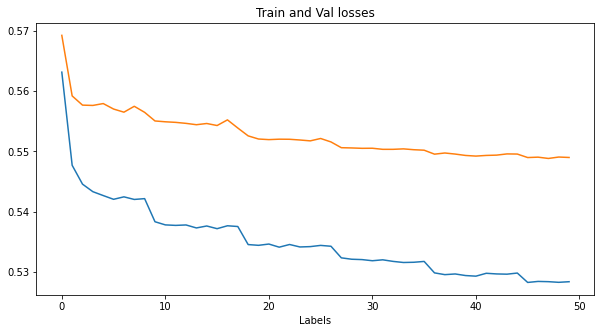

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_results["train_loss"], label="train_loss")
plt.plot(train_results["val_loss"], label="val_loss")
plt.title("Train and Val losses")
plt.xlabel("Labels")
plt.legend
plt.show()

# Evaluation

In [17]:
pred_dict = evaluate.evaluate(model=model, val_loader=val_loader)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

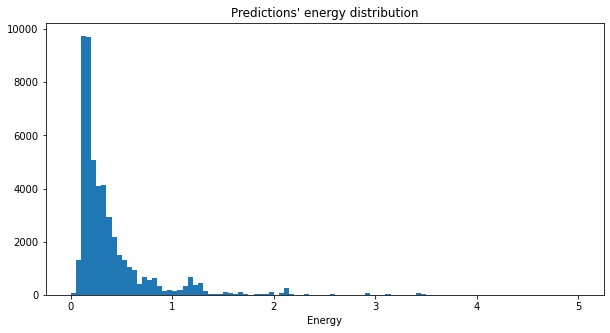

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

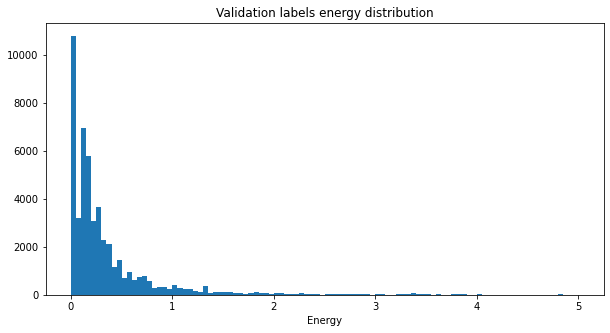

In [19]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [20]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.1860279462621192, Labels' std: 0.7301842829446544
MSE: 0.348
MAE: 0.257


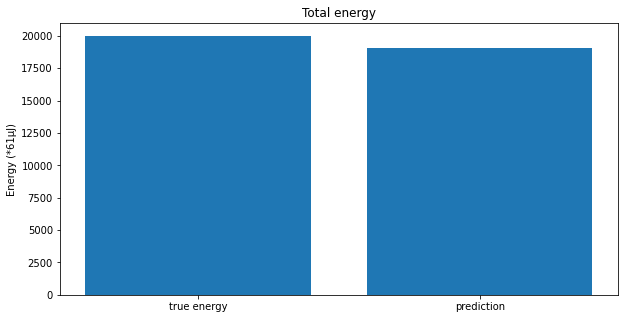

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

# Test programs prediction

In [25]:
test_preds = evaluate.predict(model=model, test_bbs=test_df.bb.tolist(), vocab=vocab)
true_energies = test_df.energy.values

In [26]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, test_preds), 3)
mae = round(mean_absolute_error(true_energies, test_preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.18474359828785508, Labels' std: 0.690261739319124
MSE: 0.311
MAE: 0.251
